In [28]:
import pandas as pd
import numpy as np
import sklearn
import scipy as sp
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from collections import defaultdict
import re
import sklearn.feature_extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing
import time
stemmer =  SnowballStemmer(language='english')

In [2]:
train_df = pd.read_csv("quora_train_data.csv")
test_df = pd.read_csv("quora_test_data.csv")

In [3]:
train_df.shape, test_df.shape

((323432, 6), (80858, 6))

### All questions (data variable)

In [4]:
# Train set
all_q1_train = list(train_df["question1"])
all_q2_train = list(train_df["question2"])
all_questions_train = all_q1_train + all_q2_train
len(all_questions_train)

646864

### Is_duplicate (target variable)

In [5]:
y_train = train_df["is_duplicate"].values
y_test = test_df['is_duplicate'].values
len(y_train), len(y_test)

(323432, 80858)

### List of questions into strings

In [6]:
print(set(type(x).__name__ for x in all_questions_train))

{'str', 'float'}


In [7]:
def cast_list_as_strings(mylist):
    """
    return a list of strings
    """
    assert isinstance(mylist, list), f"the input mylist should be a list it is {type(mylist)}"
    
    # return list(map(lambda x: str(x), all_questions)) # Slower
    return [str(s) for s in mylist]

In [8]:
all_questions_train = cast_list_as_strings(all_questions_train)
print(set(type(x).__name__ for x in all_questions_train))

{'str'}


# A) CountVectorizers

## 1. Sklearn CountVectorizer

In [9]:
count_vect = CountVectorizer()
sk_vect = count_vect.fit(all_questions_train)
sk_vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [10]:
def get_features_from_df(df, vectorizer):
    """
    returns a sparse matrix containing the features build by the count vectorizer.
    Each row should contain features from question1 and question2.
    """
    q1_casted =  cast_list_as_strings(list(df["question1"]))
    q2_casted =  cast_list_as_strings(list(df["question2"]))
    
    q1 = vectorizer.transform(q1_casted)
    q2 = vectorizer.transform(q2_casted)
    
    X_q1q2 = scipy.sparse.hstack((q1,q2))
        
    return X_q1q2

In [11]:
X_tr_q1q2 = get_features_from_df(train_df,count_vect)
X_te_q1q2  = get_features_from_df(test_df, count_vect)

X_tr_q1q2.shape, X_te_q1q2.shape

((323432, 156550), (80858, 156550))

In [12]:
logistic = LogisticRegression(solver="liblinear")
logistic.fit(X_tr_q1q2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
acc_train_0 = logistic.score(X_tr_q1q2, y_train)
acc_test_0 = logistic.score(X_te_q1q2, y_test)
acc_train_0 , acc_test_0

(0.811954290237206, 0.7536050854584581)

## 2. Simple CountVectorizer

In [14]:
class SimpleCountVectorizer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    
    def __init__(self,
                 min_word_counts=1,
                 doc_cleaner_pattern=r"[^a-zA-Z]",
                 token_pattern=r"(?u)\b\w\w+\b",
                 dtype=np.float32,
                 doc_cleaner_func=None,
                 tokenizer_func=None,
                 word_transformer_func=None):
        
        self._retype = type(re.compile('hello, world'))

        self.min_word_counts     = min_word_counts
        self.doc_cleaner_pattern = doc_cleaner_pattern
        self.token_pattern       = token_pattern
        self.dtype               = dtype
        
        self.doc_cleaner_func      = doc_cleaner_func
        self.tokenizer_func        = tokenizer_func
        self.word_transformer_func = word_transformer_func

        self.vocabulary = set()
        self.word_to_ind = {}


    def build_doc_cleaner(self, lower=True):
        """
        Returns a function that cleans undesirable substrings in a string.
        It also lowers the input string if lower=True
        """
        if self.doc_cleaner_func:
            return self.doc_cleaner_func
        else:
            if isinstance(self.doc_cleaner_pattern, self._retype):
                #clean_doc_pattern = self.doc_cleaner_pattern.sub(" ", doc)
                clean_doc_pattern = re.compile(self.doc_cleaner_pattern)
            else:
                clean_doc_pattern = re.compile(self.doc_cleaner_pattern)

            if lower:
                 return lambda doc: clean_doc_pattern.sub(" ", doc).lower()
            else:
                 return lambda doc: clean_doc_pattern.sub(" ", doc)

    def build_tokenizer(self):
        """Returns a function that splits a string into a sequence of tokens"""
        if self.tokenizer_func:
            return self.tokenizer_func
        
        else:
            token_pattern = re.compile(self.token_pattern)
            return lambda doc: token_pattern.findall(doc)

    def build_word_transformer(self):
        """Returns a stemmer or lemmaitzer if object has any"""
        
        if self.word_transformer_func:
            return self.word_transformer_func
        else:
            return lambda word: word
        
    def tokenize(self, doc):
        doc_cleaner      = self.build_doc_cleaner()
        doc_tokenizer    = self.build_tokenizer()
        doc     = doc_cleaner(doc)
        words = doc_tokenizer(doc)
            
        return words
        
    def fit(self, X):

        assert self.vocabulary == set(), "self.vocabulary is not empty it has {} words".format(len(self.vocabulary))
        assert isinstance(X,list), "X is expected to be a list of documents"
        
        i = 0
        word_to_ind = {}
        doc_cleaner      = self.build_doc_cleaner()
        doc_tokenizer    = self.build_tokenizer()
        word_transformer = self.build_word_transformer()
        
        for x in X:
            words = doc_cleaner(x)
            words = doc_tokenizer(words)
            for word in words:
                if word not in word_to_ind:
                    word_to_ind[word] = i
                    i += 1
        self.word_to_ind = word_to_ind
        self.n_features = len(word_to_ind)    
                
        self.vocabulary = set(word_to_ind.keys())
                
        return self
    
    def transform(self, X, memory_efficient=False):
        
        doc_cleaner      = self.build_doc_cleaner()
        doc_tokenizer    = self.build_tokenizer()
        word_transformer = self.build_word_transformer()      
        
        col_indices = []
        row_indices = []
        sp_data     = []
                
        if memory_efficient:
            for m, x in enumerate(X):  
                words = doc_cleaner(x)
                words = doc_tokenizer(words)
                for word in words: 
                    index = self.word_to_ind[word]
                    
                    col_indices.append(index)
                    row_indices.append(m)
                    sp_data.append(1)
                    
            encoded_X = sp.csr_matrix((sp_data, (row_indices, col_indices)), shape = (len(X) ,self.n_features)) 
                        
        else:
            
            encoded_X = np.zeros((len(X), len(self.word_to_ind)))
            for m, x in enumerate(X):  
                words = doc_cleaner(x)
                words = doc_tokenizer(words)
                for word in words: 
                    index = self.word_to_ind[word]
                    encoded_X[m, index] += 1
        
        return encoded_X
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        encoded_X = self.transform(X)
        return encoded_X
    
    def _words_in_vocab(self, X):
        
        if isinstance(X, str):
            return [w for w in self.tokenize(X) if w in self.vocabulary]
        
        X_words_in_vocab = []
        for sentence in X:
            X_words_in_vocab.append(self.tokenize(sentence))
            
        return X_words_in_vocab

In [15]:
count_vect_simple = SimpleCountVectorizer()
simple_vect = count_vect_simple.fit(all_questions_train)
simple_vect

SimpleCountVectorizer(doc_cleaner_func=None, doc_cleaner_pattern='[^a-zA-Z]',
                      dtype=<class 'numpy.float32'>, min_word_counts=1,
                      token_pattern='(?u)\\b\\w\\w+\\b', tokenizer_func=None,
                      word_transformer_func=None)

In [16]:
#X_tr_q1q2_simple = get_features_from_df(train_df, count_vect_simple)
#X_te_q1q2_simple  = get_features_from_df(test_df, count_vect_simple)

#X_tr_q1q2_simple.shape, X_te_q1q2_simple.shape

In [17]:
#logistic.fit(X_tr_q1q2_simple, y_train)

In [18]:
#acc_train_1 = logistic.score(X_tr_q1q2_simple, y_train)
#acc_test_1 = logistic.score(X_te_q1q2_simple, y_test)
#acc_train_1 , acc_test_1

In [19]:
acc_train_1 = 0.8086862153404735
acc_test_1 = 0.7522323084914294

# B) TfidfVectorizers

## 1. Sklearn TfidfVectorizer

In [20]:
tfidf_vectorizer = TfidfVectorizer()
sk_tfidf = tfidf_vectorizer.fit(all_questions_train)
sk_tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [21]:
X_tfidf_tr_q1q2 = get_features_from_df(train_df, tfidf_vectorizer)
X_tfidf_te_q1q2  = get_features_from_df(test_df, tfidf_vectorizer)

X_tfidf_tr_q1q2.shape, X_tfidf_te_q1q2.shape

((323432, 156550), (80858, 156550))

In [22]:
logistic.fit(X_tfidf_tr_q1q2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
acc_train_2 = logistic.score(X_tfidf_tr_q1q2, y_train)
acc_test_2 = logistic.score(X_tfidf_te_q1q2, y_test)
acc_train_2 , acc_test_2

(0.7935763931831111, 0.7578347226001138)

## 2. Simple TfidfVectorizer

In [24]:
class SimpleTFIDFVectorizer():
    
    def __init__(self, vocabulary, word_to_ind, tokenize, normalize_tf=True, normalize_tfidf=True):
        self.tokenize = tokenize
        self.vocabulary = vocabulary
        self.word_to_ind = word_to_ind
        self.n_features = len(word_to_ind)
        self.normalize_tf = normalize_tf
        self.normalize_tfidf = normalize_tfidf
        self.X_w = None
        self.idf = None
        self.n_documents = None
    
    def fit(self, X):
        """
        Fit TFID vectorizer to a certain corpus of documents X
        """
        assert isinstance(X,list), "You should pass a list"
        
        t1 = time.time()
        self.__build_vocabulary(X)
        self.n_documents = len(X)
        self.__compute_idf()
        print('TFIDF fit finished in',str(round(time.time()-t1, 2)),'seconds')
        
    def transform(self, X):
        """
        Transform a corpus X to its TFID vectorization
        """
        assert self.X_w is not None and self.idf is not None and self.n_documents is not None,'Fit must be performed first'
        assert isinstance(X,list), "You should pass a list"
        
        t1 = time.time()
        col_indices = []
        row_indices = []
        sp_data     = []
        
        encoded_X = None # Create an encoded_X
        for m, doc in enumerate(X):
#             print(m)
            words = self.tokenize(doc)
            for w in words:
                if w in self.word_to_ind:
                    index = self.word_to_ind[w]
                    col_indices.append(index)
                    row_indices.append(m)
                    sp_data.append(1)
#             print(doc, normalize_tf)
#             print(len(doc))
#             tf = self.__term_frequency(doc, normalize_tf)
#             tfidf = tf.multiply(self.idf)
#             if normalize_tfidf: tfidf = tfidf/sp.sparse.linalg.norm(tfidf)
#             encoded_X = sp.vstack((encoded_X, tf)) if encoded_X is not None else tfidf
        encoded_X = sp.sparse.csr_matrix((sp_data, (row_indices, col_indices)), shape=(len(X), self.n_features))
        if self.normalize_tf: encoded_X = sklearn.preprocessing.normalize(encoded_X, axis=1)
        
        encoded_X = encoded_X.multiply(self.idf)
        if self.normalize_tfidf: encoded_X = sklearn.preprocessing.normalize(encoded_X, axis=1)
        
        print('TFIDF transform finished in',str(round(time.time()-t1, 2)),'seconds')
        return encoded_X
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def __build_vocabulary(self, corpus):
        """
        This function builds X_w, a dict containing for each key, how
        many documents having that key are in our corpus.
        """
        X_w = {}

        for document in corpus:
            words = self.tokenize(document)
            for word in words:
                if word not in X_w: X_w[word] = 1
                else: X_w[word] += 1

        self.X_w = X_w
        
    def __compute_idf(self):
        col_indices = []
        row_indices = []
        sp_data     = []

        for w in self.X_w:
            docs_present = self.X_w[w]
            index = self.word_to_ind[w]
            col_indices.append(index)
            row_indices.append(0)
            sp_data.append( np.log(self.n_documents / (1 + docs_present)) )

        self.idf = sp.sparse.csr_matrix((sp_data, (row_indices, col_indices)), shape=(1, self.n_features))

    def __term_frequency(self, document, normalize=True):
        
        words = self.tokenize(document)
        col_indices = []
        row_indices = []
        sp_data     = []

        for w in words:
            if w in self.word_to_ind:
                index = self.word_to_ind[w]
                col_indices.append(index)
                row_indices.append(0)
                sp_data.append(1)
        
        tf = sp.sparse.csr_matrix((sp_data, (row_indices, col_indices)), shape=(1, self.n_features))
        
        if normalize:
            return tf.multiply(1/sp.sparse.linalg.norm(tf))
        else:
            return tf

In [29]:
tfidf_simple = SimpleTFIDFVectorizer(count_vect_simple.vocabulary, count_vect_simple.word_to_ind, count_vect_simple.tokenize)
simple_tfidf = tfidf_simple.fit(all_questions_train)
simple_tfidf

TFIDF fit finished in 33.7 seconds


In [30]:
X_tfidf_simple_tr_q1q2 = get_features_from_df(train_df, tfidf_simple)
X_tfidf_simple_te_q1q2  = get_features_from_df(test_df, tfidf_simple)

X_tfidf_simple_tr_q1q2.shape, X_tfidf_simple_te_q1q2.shape

TFIDF transform finished in 23.68 seconds
TFIDF transform finished in 24.43 seconds
TFIDF transform finished in 5.94 seconds
TFIDF transform finished in 5.99 seconds


((323432, 144312), (80858, 144312))

In [31]:
logistic.fit(X_tfidf_simple_tr_q1q2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
acc_train_3 = logistic.score(X_tfidf_simple_tr_q1q2, y_train)
acc_test_3 = logistic.score(X_tfidf_simple_te_q1q2, y_test)
acc_train_3 , acc_test_3

(0.7930878824606099, 0.7559301491503624)

# C) Comparing results

In [33]:
df_results = pd.DataFrame()
df_results["Sklearn Countvectorizer"]   = [acc_train_0, acc_test_0]
df_results["Simple Countvectorizer"]  = [acc_train_1, acc_test_1]
df_results["Sklearn TfidfVectorizer"] = [acc_train_2, acc_test_2]
df_results["Simple TfidfVectorizer"] = [acc_train_3, acc_test_3]
df_results.index=["train","test"] 

In [34]:
df_results

,Sklearn Countvectorizer,Simple Countvectorizer,Sklearn TfidfVectorizer,Simple TfidfVectorizer
train,0.811954,0.808686,0.793576,0.793088
test,0.753605,0.752232,0.757835,0.755930


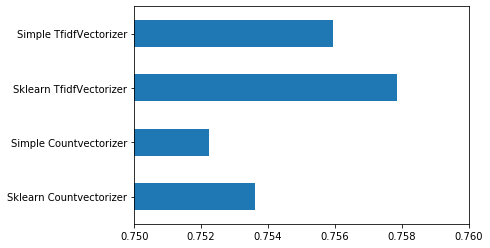

In [38]:
%matplotlib inline
df_results.T["test"].plot(kind="barh", xlim=(0.75,0.76))

In [39]:
X_tr_q1q2.shape, X_te_q1q2.shape, #X_tr_q1q2_simple.shape, X_te_q1q2_simple.shape

((323432, 156550), (80858, 156550))

In [40]:
X_tfidf_tr_q1q2.shape, X_tfidf_te_q1q2.shape, X_tfidf_simple_tr_q1q2.shape, X_tfidf_simple_te_q1q2.shape

((323432, 156550), (80858, 156550), (323432, 144312), (80858, 144312))